<a name="1"></a>
## 1 - Packages

In [18]:
import os
import random

import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Set reproducible seed
RANDOM_SEED = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("All libraries imported successfully!")

All libraries imported successfully!


<a name="1"></a>
## 2. Dataset

In [19]:
housing = fetch_california_housing(as_frame=True)
df = housing.frame.copy()
X = df.drop(columns=[housing.target.name])
y = df[housing.target.name]

print('Data shape:', X.shape)
print('Target:', housing.target.name)
print(y.shape)

# '''
print('\nHead:')
print(df.head())

print('\nDescription:')
print(df.describe().T)

corrs = df.corr()[housing.target.name].sort_values(ascending=False)
print('\nTop correlations with target:')
print(corrs.head(10))


Data shape: (20640, 8)
Target: MedHouseVal
(20640,)

Head:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  

Description:
               count         mean          std         min         25%  \
MedInc       20640.0     3.870671     1.899822    0.499900    2.563400   
HouseAge     20640.0    28.639486    12.585558    1.000000   18.000000   
AveRooms     20640.0     5.429000     2.474173    0.846154    4.440716   
AveBed

<a name="1"></a>
## 3. Data preprocessing

In [20]:
# Split the data
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.15, random_state=RANDOM_SEED)

print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)

Train: (14912, 8) Val: (2632, 8) Test: (3096, 8)


<a name="1"></a>
## 4. Polynomial regression

In [21]:
poly_degree = 2
poly_pipeline = Pipeline([
("poly", PolynomialFeatures(degree=poly_degree, include_bias=False)),
("scaler", StandardScaler()),
("ridge", Ridge(alpha=0.09))
])

poly_pipeline.fit(X_train, y_train)

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    for name, X_, y_ in (("train", X_train, y_train), ("val", X_val, y_val), ("test", X_test, y_test)):
        pred = model.predict(X_)
        mse = mean_squared_error(y_, pred)
        r2 = r2_score(y_, pred)
        print(f"{name} MSE: {mse} R2: {r2}")

evaluate_model(poly_pipeline, X_train, y_train, X_val, y_val, X_test, y_test)

train MSE: 0.42881059898750346 R2: 0.6786205326940459
val MSE: 0.42412403209690464 R2: 0.6834724354861299
test MSE: 0.4410002464684711 R2: 0.6634890390762327


<a name="1"></a>
## 5. TensorFlow Model using Polynomial Features

In [24]:
poly_tranformer = Pipeline([
    ("poly", PolynomialFeatures(degree=poly_degree, include_bias=False)),
    ("scaler", StandardScaler()),
])

poly_tranformer.fit(X_train)
X_train_poly = poly_tranformer.transform(X_train)
X_test_poly = poly_tranformer.transform(X_test)
X_val_poly = poly_tranformer.transform(X_val)

print(f"Train shape: {X_train_poly.shape}\nTest shape: {X_test_poly.shape}")

model = keras.Sequential([
    keras.layers.Input(shape=(X_train_poly.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Regression output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train_poly, y_train, validation_data=(X_val_poly, y_val), epochs=50)


Train shape: (14912, 44)
Test shape: (3096, 44)
Epoch 1/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - loss: 0.7707 - mae: 0.5726 - val_loss: 0.4340 - val_mae: 0.4759
Epoch 2/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 0.4431 - mae: 0.4438 - val_loss: 0.4753 - val_mae: 0.4718
Epoch 3/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 0.3872 - mae: 0.4266 - val_loss: 0.3652 - val_mae: 0.4397
Epoch 4/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 0.3443 - mae: 0.4117 - val_loss: 0.3613 - val_mae: 0.4257
Epoch 5/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 0.3354 - mae: 0.4061 - val_loss: 0.3491 - val_mae: 0.4189
Epoch 6/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 0.3386 - mae: 0.3983 - val_loss: 0.3643 - val_mae: 0.4261
Epoch 7/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 0.4030 - mae: 0.3988 - val_loss: 0.4469 - val_mae: 0.4256
Epoch 8/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.3386 - mae: 0.3911 - val_loss: 0.3597 - val_mae:

Train MAE: 0.3539
Validation MAE: 0.3726
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
Validation R²: 0.7822


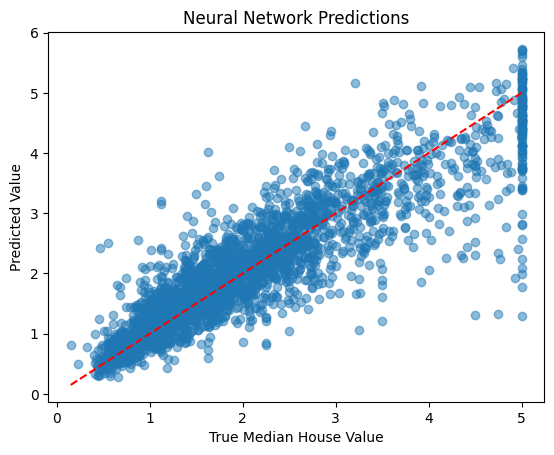

In [25]:
train_loss, train_mae = model.evaluate(X_train_poly, y_train, verbose=0)
val_loss, val_mae = model.evaluate(X_val_poly, y_val, verbose=0)

print(f"Train MAE: {train_mae:.4f}")
print(f"Validation MAE: {val_mae:.4f}")

y_val_pred = model.predict(X_val_poly).squeeze()  # flatten predictions
r2 = r2_score(y_val, y_val_pred)
print(f"Validation R²: {r2:.4f}")

plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.xlabel("True Median House Value")
plt.ylabel("Predicted Value")
plt.title("Neural Network Predictions")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # perfect line
plt.show()